# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from numpy.random import RandomState
from scipy import stats as st
import warnings
# отключить некритические предупреждения в коде
warnings.filterwarnings("ignore")





In [3]:
geo_data_0=pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1=pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2=pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
geo_data_0.head(10)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


In [5]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В каждой таблице по 100 тысяч записей. Названия столбцов - одинаковые во всех 3 датасэтах. Менять типы мы не будем.

In [8]:
geo_data_list = [geo_data_0,geo_data_1,geo_data_2]
#проверим на полные дубликаты
for data in geo_data_list:
    print(data.duplicated().value_counts()) 

False    100000
dtype: int64
False    100000
dtype: int64
False    100000
dtype: int64


In [9]:
# удалим столбец c id, для нашей задачи он не информативен
for data in geo_data_list:
    data.drop(columns=['id'],axis=1, inplace=True)
    display(data.tail(1))

,f0,f1,f2,product
99999,1.764754,-0.266417,5.722849,149.633246


,f0,f1,f2,product
99999,-3.426139,-7.794274,-0.003299,3.179103


,f0,f1,f2,product
99999,-2.551421,-2.025625,6.090891,102.775767


Text(0.5, 1.0, 'Распределение сырья в месторождении geo_data_0')

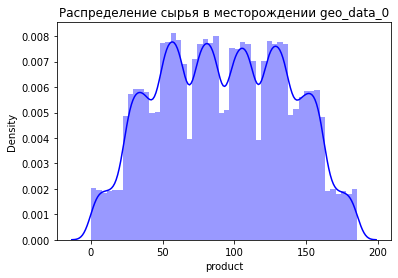

In [10]:
sns.distplot(geo_data_0['product'],  color= "b")
plt.title('Распределение сырья в месторождении geo_data_0')

Text(0.5, 1.0, 'Распределение сырья в месторождении geo_data_1')

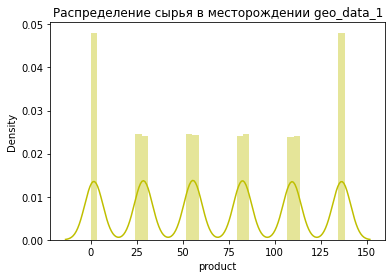

In [11]:
sns.distplot(geo_data_1['product'],  color= "y")
plt.title('Распределение сырья в месторождении geo_data_1')

Text(0.5, 1.0, 'Распределение сырья в месторождении geo_data21')

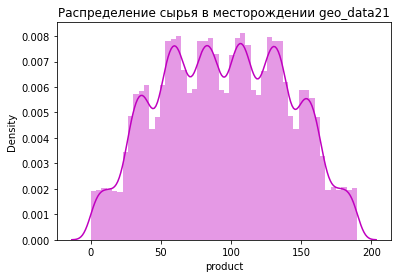

In [12]:
sns.distplot(geo_data_2['product'],  color= "m") 
plt.title('Распределение сырья в месторождении geo_data21')

Посмотрели на данные.

Выявили неинфомативный признак id. Удалили его.

Распределение: в регионе 0 и 2 близко к нормальному,в регионе 1 не нормальное.



## Обучение и проверка модели

In [13]:
# готовим выборки для обучения. Разбиваем на целевой признак и признаки
features_0=geo_data_0.drop(['product'],axis=1)
target_0=geo_data_0['product']

features_1=geo_data_1.drop(['product'],axis=1)
target_1=geo_data_1['product']

features_2=geo_data_2.drop(['product'],axis=1)
target_2=geo_data_2['product']

In [14]:
# готовим обучающую, валидную и тестовую выборку
features_train_0,features_valid_0,target_train_0,target_valid_0=train_test_split(features_0,target_0,test_size=.25,random_state=1234)
features_train_1,features_valid_1,target_train_1,target_valid_1=train_test_split(features_1,target_1,test_size=.25,random_state=1234)
features_train_2,features_valid_2,target_train_2,target_valid_2=train_test_split(features_2,target_2,test_size=.25,random_state=1234)

In [15]:
# Обучаем модель линейной регрессии
model_reg_0=LinearRegression()
model_reg_0.fit(features_train_0,target_train_0)

LinearRegression()

In [16]:
#Предсказания модели
prediction_0=model_reg_0.predict(features_valid_0)

In [17]:
mse = mean_squared_error(target_valid_0,prediction_0)
mae = mean_absolute_error(target_valid_0,prediction_0)
rmse = np.sqrt(mean_squared_error(target_valid_0,prediction_0))
r2 = r2_score(target_valid_0,prediction_0)
print('Средний запас сырья:',prediction_0.mean(),'MSE:',mse,'MAE:',mae,'RMSE:',rmse,'R2:',r2)

Средний запас сырья: 92.43045952558441 MSE: 1410.933456806986 MAE: 30.938765880476645 RMSE: 37.562394183637785 R2: 0.2740586761361865


In [18]:
# Обучаем модель линейной регрессии
model_reg_1=LinearRegression()
model_reg_1.fit(features_train_1,target_train_1)

LinearRegression()

In [19]:
#Предсказания модели
prediction_1=model_reg_1.predict(features_valid_1)

In [20]:
mse = mean_squared_error(target_valid_1,prediction_1)
mae = mean_absolute_error(target_valid_1,prediction_1)
rmse = np.sqrt(mean_squared_error(target_valid_1,prediction_1))
r2 = r2_score(target_valid_1,prediction_1)
print('Средний запас сырья:',prediction_1.mean(),'MSE:',mse,'MAE:',mae,'RMSE:',rmse,'R2:',r2)

Средний запас сырья: 68.80248249798365 MSE: 0.7991188434691269 MAE: 0.7208749581371285 RMSE: 0.8939344738117704 R2: 0.999619058765352


In [21]:
# Обучаем модель линейной регрессии
model_reg_2=LinearRegression()
model_reg_2.fit(features_train_2,target_train_2)

LinearRegression()

In [22]:
#Предсказания модели
prediction_2=model_reg_2.predict(features_valid_2)

In [23]:
mse = mean_squared_error(target_valid_2,prediction_2)
mae = mean_absolute_error(target_valid_2,prediction_2)
rmse = np.sqrt(mean_squared_error(target_valid_2,prediction_2))
r2 = r2_score(target_valid_2,prediction_2)
print('Средний запас сырья:',prediction_2.mean(),'MSE:',mse,'MAE:',mae,'RMSE:',rmse,'R2:',r2)

Средний запас сырья: 94.91573817913459 MSE: 1608.265125723965 MAE: 32.86813268581066 RMSE: 40.10318099258418 R2: 0.1983301043994069


geo_data_0.corr()

В Регионе 0 видна корреляция между Product и F2, а также обратная корреляция между признаками F0 и F1

In [24]:
geo_data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


В Регионе 1 показана почти 100-процентная коррелляция у Product и F2

In [25]:
geo_data_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


В Регионе 2 видна корреляция между Product и F2

Корреляция показывает наличие зависимости продукта от признака f2 во всех регионах, но в регионе 1 она почти 100%

In [26]:
metric_data={'geo_data_0':np.array([92.4,37.56,30.93,0.27]),'geo_data_1':np.array([68.8,0.89,0.72,0.99]),'geo_data_2':np.array([94.9,40.10,32.86,0.19])}
data=pd.DataFrame(metric_data,index=['Средний запас сырья, тыс.бареллей','RMSE','MAE','R2'])
data

,geo_data_0,geo_data_1,geo_data_2
"Средний запас сырья, тыс.бареллей",92.40,68.80,94.90
RMSE,37.56,0.89,40.10
MAE,30.93,0.72,32.86
R2,0.27,0.99,0.19


 Применяя метрики оценки модели можно сделать вывод, что лучше всего предсказано месторождение geo_data_1. Остальные месторождения предсказаны с большой ошибкой. Также можно заметить, что у месторождения (geo_data_1), которое предсказано лучше всех, меньше всего среднего запаса сырья, чем у остальных. Можно сделать вывод, что из-за большой ошибки значения среднего запаса могут быть другими.  Попробуем применить технологию Bootstrap, чтобы получить нормальное распределение данных .

## Подготовка к расчёту прибыли

In [27]:
#Введем постоянные величины
SAMPLS = 1000
MLRD = 1000000000
N=500 # При разведке региона проводится исследование 500 точек.
WELLS_NUMBER = 200# число лучших для разработки точек
BUDGET = 10**10# Бюджет на разработку месторождений — 10 млрд рублей
BURREL=450000 # При нынешних ценах один баррель сырья приносит 450 рублей дохода.
#Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
BUDGET_FOR_ONE = BUDGET / WELLS_NUMBER
Min_mean_product = BUDGET_FOR_ONE / BURREL

## Расчёт прибыли и рисков 

In [28]:
Min_mean_product
print('Для безубыточной разработки необходимо чтобы одна скважина добывала не менее:',Min_mean_product)


Для безубыточной разработки необходимо чтобы одна скважина добывала не менее: 111.11111111111111


In [29]:
print('Средний истинный запас сырья в регионе 0:', geo_data_0['product'].mean(), 'тыс. баррелей')
print('Средний истинный запас сырья в регионе 1:', geo_data_1['product'].mean(), 'тыс. баррелей')
print('Средний истинный запас сырья в регионе 2:', geo_data_2['product'].mean(), 'тыс. баррелей')

Средний истинный запас сырья в регионе 0: 92.50000000000001 тыс. баррелей
Средний истинный запас сырья в регионе 1: 68.82500000000002 тыс. баррелей
Средний истинный запас сырья в регионе 2: 95.00000000000004 тыс. баррелей


Исследуя средний истинный запас сырья в регионах, разработка месторождений в любом регионе будет убыточной.

In [30]:

def revenue(target, probabilities):
    target = pd.Series(target).reset_index(drop=True)
    probabilities = pd.Series(probabilities).reset_index(drop=True)
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:WELLS_NUMBER]
    return ((BURREL * selected.sum()) - BUDGET) / MLRD

In [31]:
revenue(target_valid_0,prediction_0)

3.4240263202475374

In [32]:
revenue(target_valid_1, prediction_1)

2.4150866966815108

In [33]:
revenue(target_valid_2, prediction_2)

2.554955424433958

Самый прибыльный регион - Регион 0, так как может принести прибыль больше трех миллиардов рублей

In [34]:
state = np.random.RandomState(12345)
values_0 =[]
for i in range(1000):
    # Делаю выборку по 500 точек 0-ого региона
    target_subsample_0=target_valid_0.reset_index(drop=True).sample(n=N,random_state=state,replace=True)
    predict_subsample_0=prediction_0[target_subsample_0.index]
    values_0.append(revenue(target_subsample_0, predict_subsample_0))
values_0 = pd.Series(values_0)


### Регион 0

In [35]:
print('средняя прибыль месторождения 0:',values_0.mean(),'млрд. рублей')

средняя прибыль месторождения 0: 0.3874697597257031 млрд. рублей


In [36]:
confidence_interval_0 =st.t.interval(0.95,df=len(values_0)-1,loc=values_0.mean(),scale =values_0.sem()) 

print("95%-ый доверительный интервал:", confidence_interval_0)

95%-ый доверительный интервал: (0.3712838758790517, 0.40365564357235445)


In [37]:
lower_0 =values_0.quantile(0.025)
upper_0 = values_0.quantile(0.975)
lower_0# 2.5% квантиль

-0.1645711767368905

In [38]:
upper_0# 97.5 квантиль

0.8724395111968266

In [39]:
demage_0 =  (values_0 < 0).mean()*100
print("Риск убытка:", demage_0)

Риск убытка: 6.9


### Регион 1

In [40]:
values_1 =[]
for i in range(1000):
    # Делаю выборку по 500 точек 0-ого региона
    target_subsample_1=target_valid_1.reset_index(drop=True).sample(n=N,random_state=state,replace=True)
    predict_subsample_1=prediction_1[target_subsample_1.index]
    values_1.append(revenue(target_subsample_1, predict_subsample_1))
values_1 = pd.Series(values_1)

In [41]:
print('средняя прибыль месторождения 1:',values_1.mean(),'млрд. рублей')

средняя прибыль месторождения 1: 0.419143064375936 млрд. рублей


In [42]:
confidence_interval_1 =st.t.interval(0.95,df=len(values_1)-1,loc=values_1.mean(),scale =values_1.sem()) 

print("95%-ый доверительный интервал:", confidence_interval_1)

95%-ый доверительный интервал: (0.4065717245153132, 0.4317144042365588)


In [43]:
lower_1 =values_1.quantile(0.025)
upper_1 = values_1.quantile(0.975)
lower_1# 2.5% квантиль

0.026000435376237824

In [44]:
upper_1# 97.5 квантиль

0.8037549240593178

In [45]:
demage_1 = (values_1 < 0).mean()*100
print("Риск убытка:", demage_1)


Риск убытка: 1.7999999999999998


### Регион 2

In [46]:
values_2 =[]
for i in range(1000):
    # Делаю выборку по 500 точек 0-ого региона
    target_subsample_2=target_valid_2.reset_index(drop=True).sample(n=N,random_state=state,replace=True)
    predict_subsample_2=prediction_2[target_subsample_2.index]
    values_2.append(revenue(target_subsample_2, predict_subsample_2))
values_2 = pd.Series(values_2)

In [47]:
print('средняя прибыль месторождения 2:',values_2.mean(),'млрд. рублей')

средняя прибыль месторождения 2: 0.35473917313989217 млрд. рублей


In [48]:
confidence_interval_2 =st.t.interval(0.95,df=len(values_2)-1,loc=values_2.mean(),scale =values_2.sem()) 
#confidence_interval_2 = (values_2.quantile(0.025), values_2.quantile(0.975)) 

print("95%-ый доверительный интервал:", confidence_interval_2)

95%-ый доверительный интервал: (0.3375581182747901, 0.37192022800499425)


In [49]:
lower_2 =values_2.quantile(0.025)
upper_2 = values_2.quantile(0.975)
lower_2# 2.5% квантиль

-0.17293983228213713

In [50]:
upper_2# 97.5 квантиль

0.8891559673071864

In [51]:
demage_2 =(values_2 < 0).mean()*100
print("Риск убытка:", demage_2)

Риск убытка: 10.6


In [52]:
geo={'geo_data_0':np.array([values_0.mean(),confidence_interval_0,demage_0,]),'geo_data_1':np.array([values_1.mean(),confidence_interval_1,demage_1]),'geo_data_2':np.array([values_2.mean(),confidence_interval_2,demage_2])}
new_data=pd.DataFrame(geo,index=['Средняя прибыль, млрд.руб','Доверительный интервал 95%','Риск убытков, %'])

In [53]:
new_data

,geo_data_0,geo_data_1,geo_data_2
"Средняя прибыль, млрд.руб",0.38747,0.419143,0.354739
Доверительный интервал 95%,"(0.3712838758790517, 0.40365564357235445)","(0.4065717245153132, 0.4317144042365588)","(0.3375581182747901, 0.37192022800499425)"
"Риск убытков, %",6.9,1.8,10.6


Оценивая средние значения прибыли после Bootstrap можно сделать выводы, что самым прибыльным районом оказался geo_data_1. Средняя прибыль по нему составляет 419.143 млн. рублей. На втором месте регион geo_data_0 со средней прибылью 387.47 млн. руб. Самым неблагоприятным районом для осваивания является geo_data_2. Средняя прибыль по нему 354.739 млн. руб. Наибольшие риски убытка в регионе geo_data_2.Они составляют 10.6%. По региону geo_data_0 риски убытков - 6.9%.Самые низкие риски убытков - 1.8% - выявлены в регионе geo_data_1. Для разработки можно рекомендовать район geo_data_1, как район с наибольшей прогнозируемой прибылью и наименьшими рисками убытков.